In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

In [331]:
data_mal = pd.read_csv('C:\\Users\\ksn\\archive\\anime.csv')
# data_mal.index = data_mal['MAL_ID']
data_mal.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [171]:
data_mal.iloc[0]['Genres']

['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space']

In [220]:
genres = []

for i in range(len(data_mal)):
    genres.extend(data_mal.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

In [323]:
data_genres = pd.DataFrame(columns=colms)
data_genres['anime_id'] = data_mal['MAL_ID']
# data_genres.index = data_genres['anime_id']
data_genres = data_genres.fillna(0)

In [324]:
for i in range(len(data_mal)):
    list_genres = data_mal.loc[i]['Genres'].split(', ')
    #print(list_genres, '\n')
    for j in list_genres:
        data_genres.at[i, j] = 1
        
data_genres.head(3)

,Dementia,Sports,Martial Arts,Unknown,Psychological,Military,Vampire,Drama,Demons,Mystery,...,Magic,Comedy,Yaoi,Super Power,Ecchi,Yuri,Parody,Thriller,Josei,anime_id
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,6


In [327]:
me['label'] = 1
# data_genres = data_genres.reset_index(drop=True)
data_genres = pd.merge(data_genres, me[['anime_id', 'label']], how='left', on='anime_id')
data_genres = data_genres.fillna(0)
data_genres.head(3)

,Dementia,Sports,Martial Arts,Unknown,Psychological,Military,Vampire,Drama,Demons,Mystery,...,Comedy,Yaoi,Super Power,Ecchi,Yuri,Parody,Thriller,Josei,anime_id,label
0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0.0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,5,0.0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,6,0.0


In [328]:
data_genres.to_csv('data_genres.csv')

Кумулятивная доля дисперсии по компонентам [  5.61547176  10.45545613  14.73863658  18.7911339   22.29592093
  25.61454657  28.76765486  31.62924957  34.43035396  37.16685645
  39.76752327  42.28352404  44.7598828   47.15227597  49.50766086
  51.83148582  54.13549809  56.41670505  58.66123055  60.88226335
  63.05813892  65.20828082  67.30024442  69.30362534  71.29701063
  73.18712719  75.05028497  76.87643915  78.65949632  80.38844045
  82.09277851  83.75439001  85.39695168  86.9648351   88.51876579
  90.01250431  91.49246035  92.87639066  94.2169852   95.53382531
  96.83217035  98.02692349  99.1506265  100.        ]


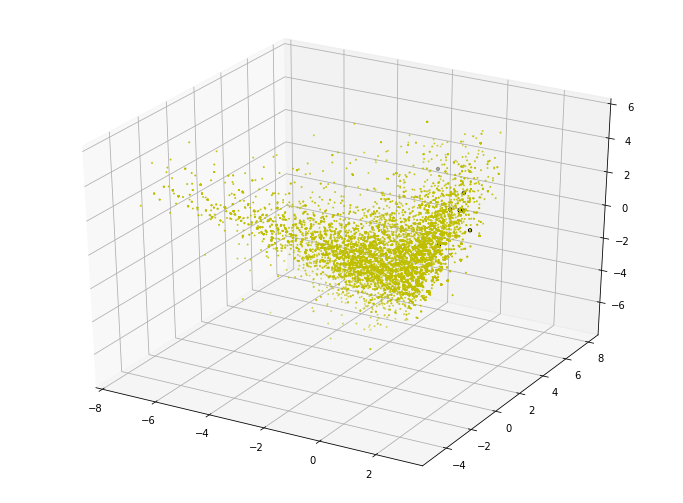

In [330]:
X_ = data_genres
label = np.array(data_genres['label'])
X_ = X_.drop(['anime_id', 'label'], axis=1)
X_ = X_.reset_index(drop=True)
X_ = X_.astype(float)
X_ = np.array(X_)
# Для начала отмасштабируем выборку
rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по столбцу
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]
        
# Найдем собственные векторы и собственные значения (англ. Eigenvalues)
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)    
eig_sum = sum(eig_values)
# Доля дисперсии, описываемая каждой из компонент
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
# Кумулятивная доля дисперсии по компонентам
cum_var_exp = np.cumsum(var_exp)
print('Кумулятивная доля дисперсии по компонентам', cum_var_exp)
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(cols,1), eig_pairs[1][1].reshape(cols,1), eig_pairs[2][1].reshape(cols,1)))
# print(f'Матрица весов W:\n', W)
Z = X_.dot(W)
y = label

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111, projection='3d')

for c, i, s in zip("yk", [0, 1], [1, 10]):
    ax.scatter(Z[y == i, 0], Z[y == i, 1], Z[y == i, 2], c=c, s=s)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [2]:
data = pd.read_csv('C:\\Users\\ksn\\archive\\rating_complete.csv')
data_100000 = data[:100000]
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [3]:
data_train = data

In [4]:
me = pd.read_csv('400000.csv')

In [6]:
popularity_anime = data_train.groupby('anime_id')['rating'].sum().reset_index().sort_values('rating', ascending=False)
popularity_anime.head(3)

,anime_id,rating
1390,1535,1587860
7437,16498,1445712
3965,5114,1239579


In [7]:
top_anime = popularity_anime.reset_index(drop=True)[:10000]
top_anime = top_anime['anime_id'].tolist()

In [8]:
popularity_anime = popularity_anime.reset_index(drop=True)
popularity_anime['rating_rank'] = popularity_anime.index
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
0,1535,0
1,16498,1
2,5114,2


In [9]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [10]:
data_train.head(3)

,user_id,anime_id,rating,rating_rank
0,0,430,9,229
1,0,1004,5,832
2,0,3010,7,4200


In [11]:
user_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,125345649
1,162615,121198749
2,68042,100797227


In [12]:
user_val = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_val.head(3)

,user_id,rating_rank
0,189037,15455
1,162615,14864
2,68042,13462


In [13]:
user_rating = pd.merge(user_rating, user_val, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,8110.362278
1,162615,8153.844793
2,68042,7487.537290


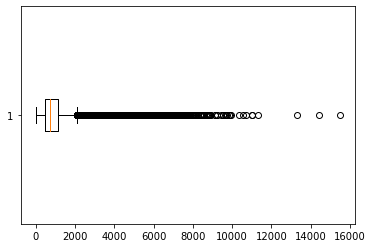

In [14]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [15]:
user_rating = user_rating.loc[(user_rating['rating_rank'] < 12000) & (user_rating['rating_rank'] > 2500)]

In [16]:
user_list = user_rating['user_id'].tolist()

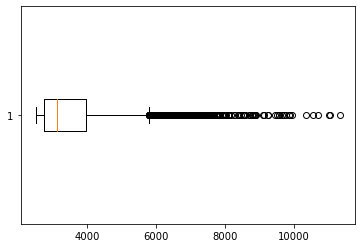

In [17]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [18]:
data_train = data_train.loc[data_train['anime_id'].isin(top_anime)]
data_train.head(3)

,user_id,anime_id,rating,rating_rank
0,0,430,9,229
1,0,1004,5,832
2,0,3010,7,4200


In [19]:
# user_activity = data_train.groupby('user_id')['user_id'].count().sort_values(ascending=False)
# m_users = user_activity[(user_activity > 10)&(user_activity < 500)]

In [20]:
# plt.boxplot(m_users, vert=False)
# plt.show()

In [21]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
data_train = pd.concat([data_train, me], ignore_index=True)
len(data_train)

4041614

In [22]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS"""

    def __init__(self, data, weighting=True):
        # your_code. Это не обязательная часть. Но если вам удобно что-либо посчитать тут - можно это сделать

        self.user_item_matrix = self.prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, self.itemid_to_id, self.userid_to_id = self.prepare_dicts(
            self.user_item_matrix)
        self.top100 = self.top_100(data)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model_als = self.fit_als(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        self.similar_users_recommender = self.fit_similar_users_recommender(self.user_item_matrix)


    @staticmethod
    def top_100(data):
        popularity = data.groupby('anime_id')['rating'].sum().reset_index()
        top_100 = popularity.sort_values('rating', ascending=False).head(100).anime_id.tolist()
        return top_100


    @staticmethod
    def prepare_matrix(data):
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='anime_id',
                                          values='rating',
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id


    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
        own_recommender = ItemItemRecommender(K=1, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender


    @staticmethod
    def fit_als(user_item_matrix):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=20,
                                        regularization=0.001,
                                        iterations=15,
                                        num_threads=0)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model


    @staticmethod
    def fit_similar_users_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных 5 похожими юзерами"""
        own_recommender = ItemItemRecommender(K=5, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        return own_recommender


    def get_als_recommendations(self, user, N):
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.model_als.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!! 999999
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_items_recommendation(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_own_recommendations(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_users_recommendation(self, user, N):
        """Рекомендуем топ-N товаров, среди купленных 5 похожими юзерами"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.similar_users_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [23]:
recommender = MainRecommender(data_train)

In [150]:
list_rec = recommender.get_als_recommendations(400000, N=100)
sum([data_mal.loc[i]['Popularity'] for i in list_rec])

16932

In [154]:
list_rec = recommender.get_own_recommendations(400000, N=100)
sum([data_mal.loc[i]['Popularity'] for i in list_rec])

14287

In [159]:
list_rec = recommender.get_similar_items_recommendation(400000, N=100)
sum([data_mal.loc[i]['Popularity'] for i in list_rec])

19720

In [163]:
list_rec = recommender.get_similar_users_recommendation(400000, N=100)
sum([data_mal.loc[i]['Popularity'] for i in list_rec])

15019